In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/Torch/chap05/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Torch/chap05/data


In [3]:
# !unzip catanddog.zip -d catanddog/

In [4]:
data_path = 'catanddog/train/'
    
transform = transforms.Compose([transforms.Resize([256, 256]), 
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor()])
train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=32, 
                                           num_workers=2, 
                                           shuffle=True)

print(f"len(train_dataset): {len(train_dataset)}")

len(train_dataset): 385


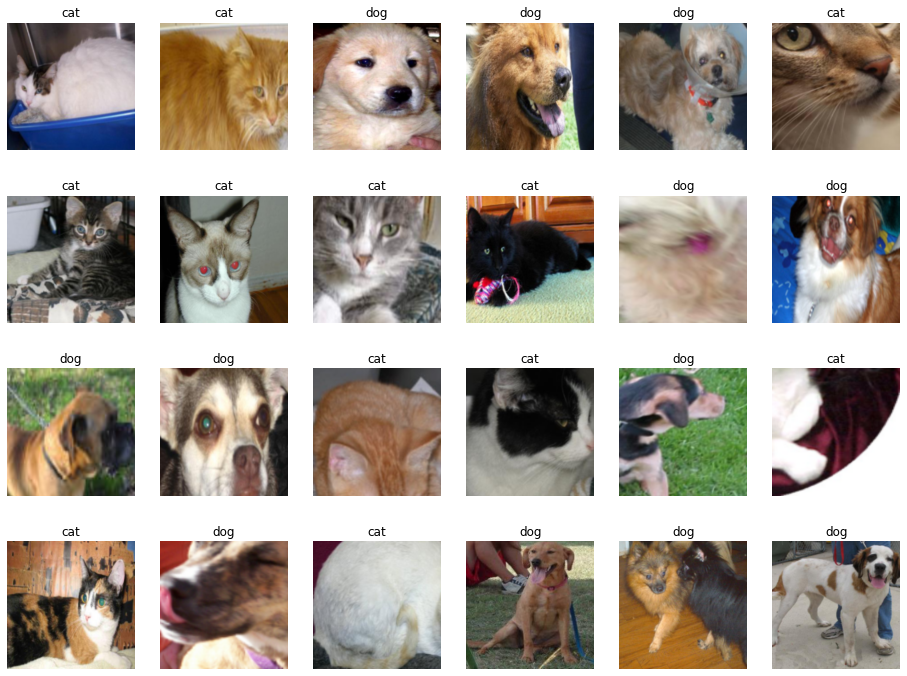

In [5]:
import numpy as np

samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16, 24))
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [6]:
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)

In [8]:
resnet18.fc = nn.Linear(512, 2)
# print(resnet18)

In [9]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0144, -0.0291, -0.0364,  ...,  0.0357,  0.0139,  0.0275],
        [-0.0271,  0.0391, -0.0436,  ..., -0.0286, -0.0246,  0.0055]])
fc.bias tensor([ 0.0207, -0.0015])


In [10]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

# TODO resnet18.fc and model.fc - nn.Linear(512, 2)
# 1) resnet18.fc = nn.Linear(512, 2) 주석 처리 시:
# - ValueError: optimizer got an empty parameter list 
# 2) model.fc = torch.nn.Linear(512, 2) 주석 처리 시:
# - (fc): Linear(in_features=512, out_features=1000, bias=True)
# 3) model 대신 resnet만 사용할 경우
# - transfer_learning_resnet18test_colab.ipynb 확인

model.fc = torch.nn.Linear(512, 2) 
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()

In [11]:
print(f"type(resnet18): {type(resnet18)}")
print(f"type(model)   : {type(model)}\n")
print(f"ID(resnet18)  : {id(resnet18)}")
print(f"ID(model)     : {id(model)}")

type(resnet18): <class 'torchvision.models.resnet.ResNet'>
type(model)   : <class 'torchvision.models.resnet.ResNet'>

ID(resnet18)  : 139694989676432
ID(model)     : 139694984547536


In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [14]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.6263 Acc: 0.6935

Epoch 1/12
----------
Loss: 0.3857 Acc: 0.8468

Epoch 2/12
----------
Loss: 0.3515 Acc: 0.8649

Epoch 3/12
----------
Loss: 0.2794 Acc: 0.9013

Epoch 4/12
----------
Loss: 0.2701 Acc: 0.8909

Epoch 5/12
----------
Loss: 0.2246 Acc: 0.9325

Epoch 6/12
----------
Loss: 0.2580 Acc: 0.8805

Epoch 7/12
----------
Loss: 0.2478 Acc: 0.8935

Epoch 8/12
----------
Loss: 0.2279 Acc: 0.8961

Epoch 9/12
----------
Loss: 0.2320 Acc: 0.8961

Epoch 10/12
----------
Loss: 0.2822 Acc: 0.8597

Epoch 11/12
----------
Loss: 0.1735 Acc: 0.9403

Epoch 12/12
----------
Loss: 0.2223 Acc: 0.8935

Training complete in 1m 17s
Best Acc: 0.940260


In [16]:
test_path = 'catanddog/test/'

transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224), 
                                transforms.ToTensor()])

test_dataset = torchvision.datasets.ImageFolder(root=test_path, 
                                                transform=transform )
                                                
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=32, 
                                          num_workers=1, 
                                          shuffle=True)

print(f"len(test_dataset): {len(test_dataset)}")

len(test_dataset): 98


In [17]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [18]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth
Acc: 0.8776

Loading model catanddog/01.pth
Acc: 0.9388

Loading model catanddog/02.pth
Acc: 0.9184

Loading model catanddog/03.pth
Acc: 0.9082

Loading model catanddog/04.pth
Acc: 0.9286

Loading model catanddog/05.pth
Acc: 0.9388

Loading model catanddog/06.pth
Acc: 0.9286

Loading model catanddog/07.pth
Acc: 0.9082

Loading model catanddog/08.pth
Acc: 0.9286

Loading model catanddog/09.pth
Acc: 0.9286

Loading model catanddog/10.pth
Acc: 0.9490

Loading model catanddog/11.pth
Acc: 0.9592

Loading model catanddog/12.pth
Acc: 0.9592

Validation complete in 1m 9s
Best Acc: 0.959184


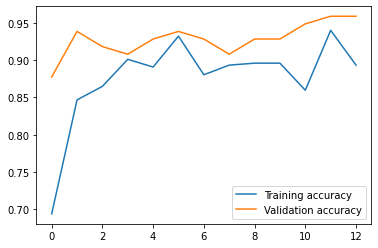

In [19]:
plt.plot(train_acc_hist, label='Training accuracy')
plt.plot(val_acc_hist, label='Validation accuracy')
plt.legend()
plt.show()

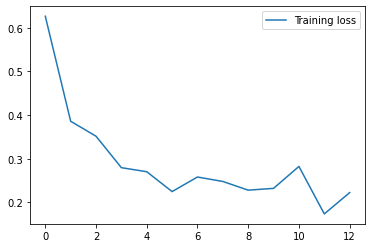

In [20]:
plt.plot(train_loss_hist, label='Training loss')
plt.legend()
plt.show()

In [21]:
def im_convert(tensor):  
    image=tensor.clone().detach().numpy()  
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  
    return image  

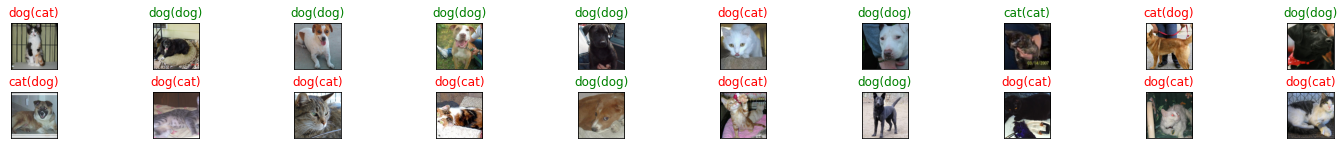

In [22]:
classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)  
images, labels = dataiter.next()  
output = model(images)  
_, preds=torch.max(output,1) 

fig = plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    ax.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),
                                 str(classes[labels[idx].item()])),
                 color=("green" if preds[idx]==labels[idx] else "red"))  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0.5)
plt.show()  